# BayesLOSVD and DYNAMITE

This notebook will show how to run DYNAMITE orbit-based models using [BayesLOSVD](https://github.com/jfalconbarroso/BAYES-LOSVD) output. BayesLOSVD is a Python library for the non-parametric extraction of the Line-Of-Sight Velocity Distributions (LOSVDs) in galaxies. Rather than describe the LOSVD using Gauss-Hermite expansion, BayesLOSVD represents the LOSVD in a *histogram* format.

1. [An example galaxy: NGC4550](#NGC4550)
2. [Data prepearion](#datprep)
3. [A look at the BayesLOSVD data](#data_firstlook)
4. [Running DYNMAITE](#run_dyn)

<a id="NGC4550"></a>
## An example galaxy: NGC4550

We will model the galaxy NGC4550, which has a complex LOSVD. The following is taken from Figure 7 of Falcón-Barroso & Martig 2020, showing LOSVDs extracted using BayesLOSVD at three regions,

<img src="NGC4550_input/bayeslosvd_extractions.png" width="400">

We see clearly bimodal LOSVDs in the galaxy outskirts, indicating a strong counter-rotating stellar component.

<a id="datprep"></a>
## Data preparation

We require the ``*_results.hdf5`` output file from BayesLOSVD. Two such files for NGC4550 have been kindly provided by Jesus Falcón-Barroso, and can be found in the directory `NGC4550_input`. They differ in the form of LOSVD regularisation used,
- `NGC4550_SAURON-SP_results.hdf5`: using simplex regularisation
- `NGC4550_SAURON-RW_results.hdf5`: using random walk regularisation

These ``*_results.hdf5`` files contains LOSVD constraints for all spatial regions. For more details, and instructions on creating your own ``*_results.hdf5`` files, see the [BayesLOSVD](https://github.com/jfalconbarroso/BAYES-LOSVD) documentation.

To prepeare this data for use in DYNAMITE, we must

1. convert kinematics to Astropy ECSV file format
2. add the PSF to the kinematics file header
3. create the auxillary `aperture.dat` and `bins.dat` files
4. get MGE data (in Astropy ECSV format)

This can be done as follows,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import dynamite as dyn
print('Using DYNAMITE version:', dyn.__version__)
    
BayesLOSVD = dyn.kinematics.BayesLOSVD(weight=1.,
                                       hist_width=1,
                                       hist_center=0,
                                       hist_bins=0,
                                       type='BayesLOSVD')
infile = 'NGC4550_input/NGC4550_SAURON-SP_results.hdf5'
outfile = 'NGC4550_input/dynamite_input/bayes_losvd_kins.ecsv'
BayesLOSVD.write_losvds_to_ecsv_format(infile, outfile=outfile)

Using DYNAMITE version: 2.0.0


We next add the PSF to the kinematics. The seeing - from Table 3 of [Emsellem et al 2004](https://academic.oup.com/mnras/article/352/3/721/1210712) - has FWHM of 2.1 arcsec. We convert this to a Gaussian sigma, and add to the header of the kinematics file,

In [2]:
seeing_fwhm = 2.1
seeing_gauss_sigma = seeing_fwhm/2.35
# add the psf to file header
BayesLOSVD.add_psf_to_datafile(sigma=[seeing_gauss_sigma],
                               weight=[1.],
                               datafile=outfile)

# re-create the BayesLOSVD object reading in the complete kinematics file
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile=outfile,
                                       weight=1.,
                                       type='BayesLOSVD')

Next create the auxillary `aperture.dat` and `bins.dat` files. This will require the galaxy's position angle. Table 3 of [Emsellem et al 2004](https://academic.oup.com/mnras/article/352/3/721/1210712), gives PA = 0.

In [3]:
position_angle = 0.
angle_deg = 90. - position_angle
dyn_input_direc = 'NGC4550_input/dynamite_input/'
BayesLOSVD.write_aperture_and_bin_files(filename=infile,
                                        angle_deg=angle_deg,
                                        aperture_filename=dyn_input_direc+'aperture.dat',
                                        bin_filename=dyn_input_direc+'bins.dat')

Finally we need the Multi Gaussian Expansion. MGEs for Atlas3D galaxies (including NGC4550) can be found under the link for the *MGE parameters for the deconvolved r-band surface brightness* on the [Atlas3D page](http://www-astro.physics.ox.ac.uk/atlas3d/). The MGE NGC4550 is provided in ``NGC4550_input/dynamite_input/``. We have already manually copied and pasted the MGE-data into the required Astropy ECSV format.

The input directory `NGC4550_input` now contains all 4 required files:
- ``mge_NGC4550.ecsv``
- ``NGC4550_bayeslovd_kins.ecsv``
- ``aperture.dat``
- ``bins.dat``

<a id="data_firstlook"></a>
## A look at the BayesLOSVD data

We can take a look at the BayesLOSVD data. First let's read the data-files, and auxillary files, into a `dyn.kinematics.BayesLOSVD` objects,

In [4]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile=outfile,
                                       aperturefile=dyn_input_direc+'aperture.dat',
                                       binfile=dyn_input_direc+'bins.dat',
                                       weight=1.,
                                       type='BayesLOSVD')

The table has one row per spatial (in this case Voronoi) bin, and the following columns:

- binID_BayesLOSVD: the bin ID used internally in BayesLOSVD 
- binID_dynamite: the bin ID used internally in DYNMAITE 
- v: the mean velocity in the bin
- sigma: the velocity dispersion in the bin
- xbin/ybin : the co-ords of the bin centers
- losvd: array holding the LOSVD 
- dlosvd: array holding LOSVD uncertainties, given by 68% credible intervals per velocity bin (assumed independent)

BayesLOSVD represents the LOSVD as a sequence of weights. Details of the velocity array are stored as metadata to the data table. Details of the LOSVD velocity array are stored as metadata to the data table,

In [5]:
print('Bayes-LOSVD table contains meta-data about: ', BayesLOSVD.data.meta.keys())
print('     velocity spacing of bins = ', BayesLOSVD.data.meta['dv'])
print('     number of spatial bins = ', BayesLOSVD.data.meta['nbins'])
print('     number of velocty bins = ', BayesLOSVD.data.meta['nvbins'])
print('     etc...')

Bayes-LOSVD table contains meta-data about:  odict_keys(['dv', 'nbins', 'nvbins', 'vcent', 'PSF'])
     velocity spacing of bins =  60.0
     number of spatial bins =  196
     number of velocty bins =  23
     etc...


To plot kinematic maps, we can get get the `map_plotter` function from the kinematics object,

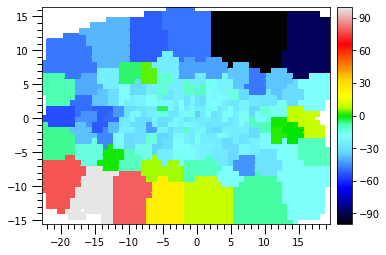

In [6]:
map_plotter = BayesLOSVD.get_map_plotter()
map_plotter(BayesLOSVD.data['v'],
            cmap='sauron',
            vmin=-100,
            vmax=100,
            colorbar=True)

The velocity map is not centered at 0. Let's center at the galaxy's systemic velocity. We could either provide this directly, or specify that we want the `flux_weighted` mean velocity calculated from the kinematic data itself,

In [7]:
BayesLOSVD.center_v_systemic(v_systemic='flux_weighted')
BayesLOSVD.save_data_table(outfile)

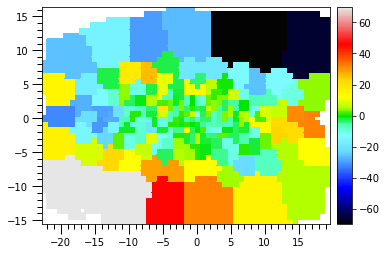

In [8]:
map_plotter(BayesLOSVD.data['v'],
            cmap='sauron',
            vmin=-70,
            vmax=70,
            colorbar=True)

And we can pick a specific bin, and plot the LOSVD there,

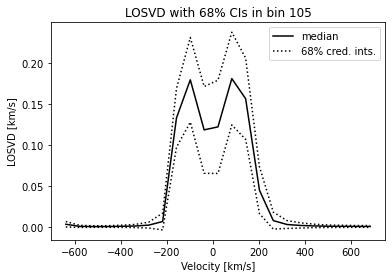

In [9]:
bin_id = 105

losvd_i = BayesLOSVD.data['losvd'][bin_id,:]
dlosvd_i = BayesLOSVD.data['dlosvd'][bin_id,:]
vcent = BayesLOSVD.data.meta['vcent']
plt.plot(vcent, losvd_i, '-k', label='median')
plt.plot(vcent, losvd_i+dlosvd_i, ':k', label='68% cred. ints.')
plt.plot(vcent, losvd_i-dlosvd_i, ':k')
plt.gca().set_xlabel('Velocity [km/s]')
plt.gca().set_ylabel('LOSVD [km/s]')
_ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_id}')
plt.gca().legend()
plt.show()

For `bin_id=105` we see that the galaxy has a bimodal LOSVD (albeit with quite large uncertainties).

The following are technical notes about BayesLOSVD data. If you're mainly interested in running DYNAMITE, you can skip below to the section [*Running DYNAMITE*](#run_dyn).

#### Note 1: bin ID's

The differences between `binID_BayesLOSVD` and `binID_DYNAMITE` are that: 
- `binID_BayesLOSVD` are zero-indexed, `binID_DYNAMITE` one-indexed. This is for compatibility with Fortran code,
- `binID_BayesLOSVD` may have some gaps (as some bins may be masked) while DYNAMITE assumes the binIDs increase without gaps
You shouldn't need to worry about this difference as bin IDs are handled internally, but be aware that of the difference for any later analysis.

#### Note 2: LOSVD normalisations

BayesLOSVD samples the multi-dimensional posterior on the LOSVD weights $L_i$. The full multidimensional posterior is not saved by defaut, however. What is saved, and what is given in the table above, is the median and 68% Bayesian credible intervals for the weight in each velocity bin.

One important effect of this is on LOSVD normalisation. The posterior samples created by BayesLOSVD are normnalised to 1 i.e. 

$$
\sum_i L_i = 1
$$

(this is acheieved by using the `simplex` datatype in STAN). The default results file, however, gives median values per velocity bin. These are *not* normalised the same way. Let's call these median value,

$$
l_i = \mathrm{median}(L_{i})
$$

and look at a histogram of the sums of the $l_i$ in each spatial bin,

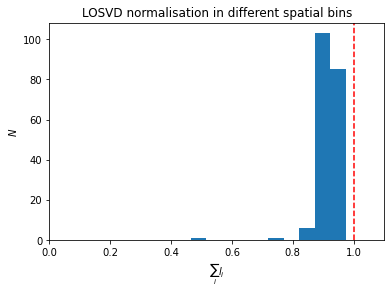

In [10]:
plt.hist(np.sum(BayesLOSVD.data['losvd'], 1))
plt.axvline(1., ls='--', color='r')
plt.gca().set_xlabel('$\sum_i l_{i}$')
plt.gca().set_ylabel('$N$')
plt.gca().set_xlim(0, 1.1)
_ = plt.gca().set_title('LOSVD normalisation in different spatial bins')

This peaks around 0.9 and, in some cases, is as low as 0.5. 

#### Note 3: calculating moments

When calculating LOSVD moments, we must acccount for the fact that LOSVDs are not normalised. Let's define the *normalised LOSVD* as

$$
\hat{l}_{i} = \frac{l_{i}}{\sum_i l_{i}}
$$

The quantity $\hat{l}_{i}$ is what we have used to make point estimates of the the LOSVD mean and standard deviation, which appear in the `v` and `sigma` columns of the data-table,

$$
v = \sum_i v_i * \hat{l}_{i}
$$

$$
\sigma = \left[ \sum_i (v_i-v)^2 * \hat{l}_{i} \right]^{\frac{1}{2}}
$$

#### Note 4: inflated velocity dispersions

Let's compare the BayesLOSVD result with a Gaussian LOSVD approximation in a particular bin,

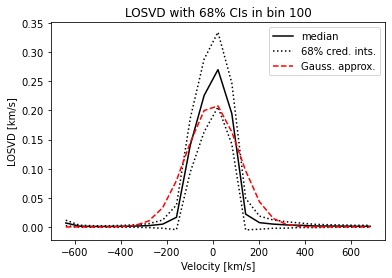

In [11]:
bin_id = 100

# plot BayesLOSVD result
losvd_i = BayesLOSVD.data['losvd'][bin_id,:]
dlosvd_i = BayesLOSVD.data['dlosvd'][bin_id,:]
vcent = BayesLOSVD.data.meta['vcent']
plt.plot(vcent, losvd_i, '-k', label='median')
plt.plot(vcent, losvd_i+dlosvd_i, ':k', label='68% cred. ints.')
plt.plot(vcent, losvd_i-dlosvd_i, ':k')

# plot Gaussian approximation
v = BayesLOSVD.data['v'][bin_id]
sigma = BayesLOSVD.data['sigma'][bin_id]
nrm = stats.norm(v, sigma)
pdf = nrm.pdf(vcent)
plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='Gauss. approx.')

# labels
plt.gca().set_xlabel('Velocity [km/s]')
plt.gca().set_ylabel('LOSVD [km/s]')
_ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_id}')
plt.gca().legend()
plt.show()

The Gaussian approximation is much wider then the median BayesLOSVD result. Why is this? Let's look at the this plot again, this time on a log-scale,

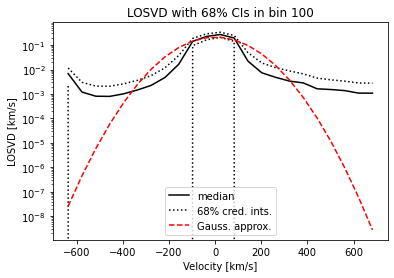

In [12]:
bin_id = 100

# plot BayesLOSVD result
losvd_i = BayesLOSVD.data['losvd'][bin_id,:]
dlosvd_i = BayesLOSVD.data['dlosvd'][bin_id,:]
vcent = BayesLOSVD.data.meta['vcent']
plt.plot(vcent, losvd_i, '-k', label='median')
plt.plot(vcent, losvd_i+dlosvd_i, ':k', label='68% cred. ints.')
plt.plot(vcent, losvd_i-dlosvd_i, ':k')

# plot Gaussian approximation
v = BayesLOSVD.data['v'][bin_id]
sigma = BayesLOSVD.data['sigma'][bin_id]
nrm = stats.norm(v, sigma)
pdf = nrm.pdf(vcent)
plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='Gauss. approx.')

# labels
plt.gca().set_xlabel('Velocity [km/s]')
plt.gca().set_ylabel('LOSVD [km/s]')
_ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_id}')
plt.gca().legend()
plt.gca().set_yscale('log')
plt.show()

We see that BayesLOSVD does not force the LOSVD to decay at large velocities. The fat tails give rise to large standard deviations. Therefore, the `sigma` values in the data table are unrepresentative of the width of the main body of the distribution.

For this reason, sigma-maps for BayesLOSVD output are not recommended. By default, for BayesLOSVD kinematic maps we will only plot mean velocities. In the future, we may extend this to plot LOSVD quantiles.

<a id="run_dyn"></a>
## Running DYNAMITE 

#### 1. Prepare the configuration file

Next prepare the DYNAMITE congfiguration file. We've included this file `NGC4550_config.yaml` in this directory. Here, we highlight a few importnat entries which are specific to fiting BayesLOSVD data. Firstly, we have to specify the type of the kinemtics as `BayesLOSVD`, i.e.

    system_components:
    ...
        stars:
            ...
            kinematics:
                sauron:
                    weight: 1.0
                    type: BayesLOSVD
                    datafile: "bayes_losvd_kins.ecsv"
                    aperturefile: "aperture.dat"
                    binfile: "bins.dat"

and ensure the `type` of the `weight_solver` is `NNLS` (since the aleternative, `LegacyWeightSolver` is incompatible with BayesLOSVD data), i.e.

    weight_solver_settings:
        type: "NNLS"
        lum_intr_rel_err: 0.01
        sb_proj_rel_err: 0.02
        nnls_solver: 'scipy'

Read the configuration file in,

In [13]:
c = dyn.config_reader.Configuration('NGC4550_config.yaml', reset_logging=True)

[INFO] 18:30:07 - dynamite.config_reader.Configuration - Config file NGC4550_config.yaml read.
[INFO] 18:30:07 - dynamite.config_reader.Configuration - io_settings...
[INFO] 18:30:07 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 18:30:07 - dynamite.config_reader.Configuration - model_components...
[INFO] 18:30:07 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 18:30:07 - dynamite.config_reader.Configuration - orblib_settings...
[INFO] 18:30:07 - dynamite.config_reader.Configuration - weight_solver_settings...
[INFO] 18:30:07 - dynamite.config_reader.Configuration - Will attempt to recover partially run models.
[INFO] 18:30:07 - dynamite.config_reader.Configuration - parameter_space_settings...
[INFO] 18:30:07 - dynamite.config_reader.Configuration - multiprocessing_settings...
[INFO] 18:30:07 - dynamite.config_reader.Configuration - legacy_settings...
[INFO] 18:30:07 - dynamite.config_reader.Configuration - System assembled
[INFO] 18:30:07 - 

#### 2. Run the models

This will run two iterations, producing 5 models in total. It should take around 7 minutes with 4 cpus.

In [14]:
# delete previous output if available
c.remove_existing_orblibs()
c.remove_existing_all_models_file(wipe_other_files=False)
c.backup_config_file(keep=3, delete_other=True)

[INFO] 18:30:07 - dynamite.config_reader.Configuration - Model output tree NGC4550_output/models/ removed.
[INFO] 18:30:07 - dynamite.model.AllModels - No previous models (file NGC4550_output/all_models.ecsv) have been found: Making an empty table in AllModels.table
[INFO] 18:30:07 - dynamite.config_reader.Configuration - Instantiated empty AllModels object
[INFO] 18:30:07 - dynamite.config_reader.Configuration - Config file backup: NGC4550_output/NGC4550_config_000.yaml.


In [15]:
import time

t = time.perf_counter()

mod_iter = dyn.model_iterator.ModelIterator(config=c)

delta_t = time.perf_counter()-t
print(f'Computation time: {delta_t} seconds = {delta_t/60} minutes')

[INFO] 18:30:07 - dynamite.model_iterator.ModelIterator - LegacyGridSearch: "iteration 0"
[INFO] 18:30:07 - dynamite.parameter_space.LegacyGridSearch - LegacyGridSearch added 1 new model(s) out of 1
[INFO] 18:30:07 - dynamite.model_iterator.ModelInnerIterator - ... running model 1 out of 1
[INFO] 18:30:07 - dynamite.orblib.LegacyOrbitLibrary - Calculating initial conditions
[INFO] 18:32:45 - dynamite.orblib.LegacyOrbitLibrary - ...done - cmd_orb_start exit code 0. Logfile: NGC4550_output/models/orblib_000_000/datfil/orbstart.log.
[INFO] 18:32:45 - dynamite.orblib.LegacyOrbitLibrary - Integrating orbit library tube orbits
[INFO] 18:33:02 - dynamite.orblib.LegacyOrbitLibrary - ...done - cmd_tube_orbs exit code 0. Logfiles: NGC4550_output/models/orblib_000_000/datfil/orblib.log, NGC4550_output/models/orblib_000_000/datfil/triaxmass.log, NGC4550_output/models/orblib_000_000/datfil/triaxmassbin.log.
[INFO] 18:33:02 - dynamite.orblib.LegacyOrbitLibrary - Integrating orbit library box orbits


Computation time: 415.162311892 seconds = 6.919371864866666 minutes


Look at the summary table,

In [16]:
c.all_models.table

m-black_hole,a-black_hole,c-dm_halo,f-dm_halo,q-stars,p-stars,u-stars,ml,chi2,kinchi2,time_modified,orblib_done,weights_done,all_done,which_iter,directory
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,bool,bool,bool,int64,object
1000000.0,0.001,10.0,1.0,0.1,0.99,0.9999,3.0,45254.77028546628,4662.895095316964,2022-02-04T17:33:20.000,True,True,True,0,orblib_000_000/ml3.00/
1000000.0,0.001,10.0,0.31622776601683794,0.1,0.99,0.9999,3.0,49077.812893798335,4680.910306046702,2022-02-04T17:36:45.000,True,True,True,1,orblib_001_000/ml3.00/
1000000.0,0.001,10.0,3.1622776601683795,0.1,0.99,0.9999,3.0,39666.1034326081,4647.504601468599,2022-02-04T17:36:45.000,True,True,True,1,orblib_001_001/ml3.00/
1000000.0,0.001,10.0,1.0,0.1,0.99,0.9999,2.0,46282.04961472527,5676.680111299871,2022-02-04T17:36:52.000,True,True,True,1,orblib_000_000/ml2.00/
1000000.0,0.001,10.0,1.0,0.1,0.99,0.9999,4.0,46245.06645726494,5649.872734261569,2022-02-04T17:36:52.000,True,True,True,1,orblib_000_000/ml4.00/


#### 3. Look at plots of the results

Some plots have been automatically created as the models were run, stored in the directory `NGC4550_output/plots/`. Let's look at some.

##### Kinemtic map

`NGC4550_output/plots/kinematic_map_sauron.png`

<img src="NGC4550_output/plots/kinematic_map_sauron.png" width="800">

The right half shows a map of the reduced chi2 of the best fitting orbit-based model to the observed LOSVD. The left half shows nine examples, which have been chosen to span the variety in the observed kinematics. We see that in some locations (e.g. 1, 2, 5, 9) the observed LOSVD is fit well, however in many others it has not. In particular, some bins (e.g. 7, 8) have very *spiky* observed LOSVDs while others (e.g. 3, 6) have peak at the most negative velocitites which is most likely an artifict. 

To progress, we would 

##### Chi2 evolution

`NGC4550_output/plots/kinchi2_progress_plot.png`

<img src="NGC4550_output/plots/kinchi2_progress_plot.png" width="500">

##### Chi2 distribution against model parameters

`NGC4550_output/plots/kinchi2_plot.png`

<img src="NGC4550_output/plots/kinchi2_plot.png" width="300">

In this case only two parameters have been left free, and only a small handful of models have been evaluated. As more models exploring more of parameter space, this plot will begin to look more interesting!